In [1]:
from core.runner import Runner
import tensorflow as tf

grid_dim = 2
grid_length = 8

runner = Runner(grid_dimension=grid_dim, grid_length=grid_length)

2022-12-06 12:27:00.206513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import time

batch_size = tf.constant(50)
n_iterations = tf.constant(1000)

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 12.7644072
Iteration: 100 Average Loss: 8.88410759
Iteration: 200 Average Loss: 9.02849197
Iteration: 300 Average Loss: 7.89116192
Iteration: 400 Average Loss: 5.03806353
Iteration: 500 Average Loss: 4.63096809
Iteration: 600 Average Loss: 4.48324633
Iteration: 700 Average Loss: 4.79602289
Iteration: 800 Average Loss: 4.32116318
Iteration: 900 Average Loss: 4.21371651
Time Elapsed: 17.92516803741455 s


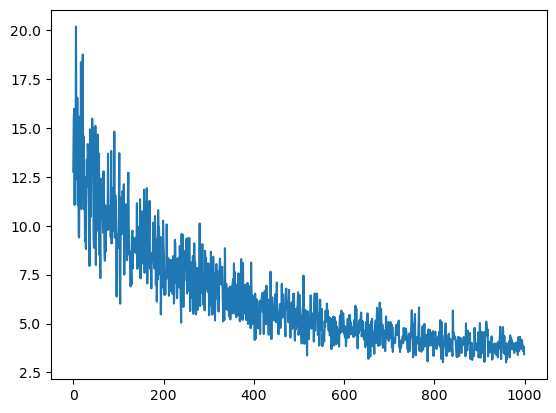

In [3]:
import matplotlib.pyplot as plt

plt.plot(ave_losses.numpy())

In [4]:
# ~3m 27s -> tf.function on main agent methods
# ~3m 17s -> tf.function on all

# ~1m 39.5s, 1m 14s -> tf.function on _generate_traj only
# ~1m 2s, 59.3s -> tf.function on _generate_traj + main agent methods
# ~1m 6s, 58.9s -> tf.function on all

# ~31s, 26.2s -> tf.function _training_step + all
# ~25.4s, 26.8s -> tf.function entire training loop + all

In [4]:
agent_distr = runner._get_normalized_agent_sample_distribution(5000)
agent_distr

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.1576, 0.1362, 0.004 , 0.0046, 0.0058, 0.0024, 0.0244, 0.0254],
       [0.1462, 0.1302, 0.006 , 0.004 , 0.0078, 0.0064, 0.036 , 0.0336],
       [0.0064, 0.0034, 0.    , 0.    , 0.0004, 0.0002, 0.0006, 0.0012],
       [0.0036, 0.005 , 0.0002, 0.    , 0.    , 0.0002, 0.0018, 0.0022],
       [0.004 , 0.0042, 0.0002, 0.0008, 0.0008, 0.0002, 0.0016, 0.0014],
       [0.0034, 0.0066, 0.0002, 0.0002, 0.    , 0.0004, 0.0026, 0.0038],
       [0.0192, 0.0262, 0.0016, 0.0028, 0.0016, 0.0008, 0.0186, 0.0256],
       [0.017 , 0.0264, 0.0008, 0.0028, 0.0024, 0.0006, 0.0244, 0.043 ]],
      dtype=float32)>

In [5]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)
env_distr

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[4.9890354e-02, 4.9890354e-02, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 4.9890354e-02, 4.9890354e-02],
       [4.9890354e-02, 9.9730864e-02, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 9.9730864e-02, 4.9890354e-02],
       [4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05],
       [4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05],
       [4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05],
       [4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 4.9840513e-05, 4.9840513e-05],
       [4.9890354e-02, 9.9730864e-02, 4.9840513e-05, 4.9840513e-05,
        4.9840513e-05, 4.9840513e-05, 9.9730864e-02, 4.9890354

In [9]:
import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    assert max_expected != 0
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

    frac_l1_errors = np.abs(result - expected) / max_expected
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
        errors_per_interval = frac_l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            errors.append(errors_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots()
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.5)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

[array([1.3053652e+00, 6.5243274e-01, 4.9975014e-04, ..., 1.0832233e-01,
       4.9975014e-04, 4.9975014e-04], dtype=float32), array([8.640804  , 2.6555903 , 0.5002499 , 0.5002499 , 0.9144371 ,
       0.26150462, 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 2.6555903 , 0.5879709 , 0.5002499 , 0.5002499 ,
       0.47914878, 0.39142784, 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.39142784, 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 , 0.5002499 ,
       0.5002499 , 0.5002499 , 0.39142784, 0.5002499 , 2.220302  ,
  

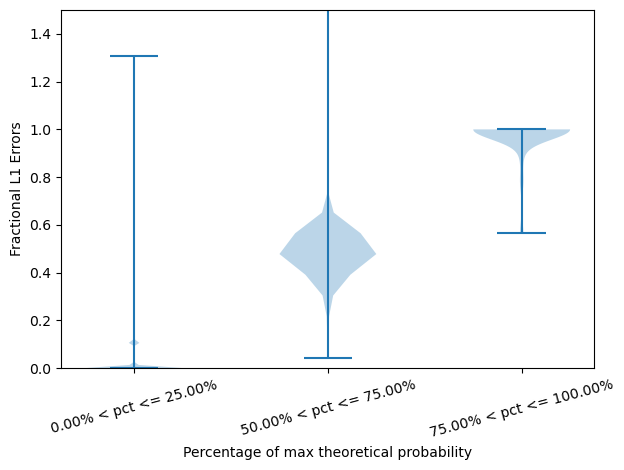

In [10]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [1]:
import numpy as np
import tensorflow as tf

class PolicyNetwork(tf.keras.Model):
    def __init__(self, n_hidden, n_output_1, n_output_2):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_output_1 = n_output_1
        self.n_output_2 = n_output_2
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(self.n_hidden)
        self.dense_2 = tf.keras.layers.Dense(self.n_output_1)
        self.dense_3 = tf.keras.layers.Dense(self.n_output_2)
    
    def call(self, data_input):
        hidden = self.flatten(data_input)
        hidden = self.dense_1(hidden)
        hidden = tf.keras.activations.tanh(hidden)
        output_1 = self.dense_2(hidden)
        output_2 = self.dense_3(hidden)
        return output_1, output_2

class Agent:
    NEG_INF = -10000000000.0
    def __init__(self, env_grid_length):
        self.policy = PolicyNetwork(40, 5, 6)
        self.env_grid_length = env_grid_length
        
    def backward_action(self, current_position):
        encoded_position = tf.one_hot(
            current_position, depth=self.env_grid_length, axis=-1
        )
        action_logits = self.policy.predict(encoded_position)[0]
        
        back_coord_mask = tf.math.equal(current_position, 0)
        masked_logits = self._mask_action_logits(
            action_logits, back_coord_mask
        )
        
        action_indices = tf.random.categorical(masked_logits, 1)
        encoded_actions = tf.one_hot(
            tf.reshape(action_indices, shape=(-1,)), depth=5, dtype=tf.int32
        )
        
        is_at_origin = tf.math.reduce_all(
            back_coord_mask, axis=1, keepdims=True
        )
        action_mask = tf.cast(
            tf.math.logical_not(is_at_origin), 
            dtype=tf.int32
        )
        back_actions = encoded_actions*action_mask
        return back_actions
    
    def forward_action(self, current_position, still_sampling):
        encoded_position = tf.one_hot(
            current_position, depth=self.env_grid_length, axis=-1
        )
        action_logits = self.policy.predict(encoded_position)[1]
        
        forward_coord_mask = tf.math.equal(current_position, self.env_grid_length-1)
        masked_logits = self._mask_action_logits(
            action_logits, forward_coord_mask
        )
        action_indices = tf.random.categorical(masked_logits, 1)
        encoded_actions = tf.one_hot(
            tf.reshape(action_indices, shape=(-1,)), depth=6, dtype=tf.int32
        )

        forward_actions = encoded_actions*still_sampling
        updated_still_sampling = (
            still_sampling - tf.reshape(forward_actions[:, -1], shape=(-1, 1))
        )
        return forward_actions, updated_still_sampling
    
    def _mask_action_logits(self, action_logits, mask):
        avoid_inds = tf.where(mask)
        # Need validation that masked are not sampled
        masked_logits = tf.tensor_scatter_nd_add(
            action_logits, avoid_inds, 
            tf.constant([self.NEG_INF]*avoid_inds.shape[0])
        )
        return masked_logits
        
    def calculate_log_proba_ratios(self, trajectories, backward_actions, forward_actions):
        reshaped_positions = tf.reshape(trajectories, shape=(-1, 5))
        encoded_positions = tf.one_hot(
            reshaped_positions, 
            depth=self.env_grid_length, axis=-1
        )
        backward_logits, forward_logits = self.policy.predict(encoded_positions)
        
        back_coord_mask = tf.math.equal(reshaped_positions, 0)
        backward_log_probas = self._action_log_probas(
            backward_logits, back_coord_mask, backward_actions
        )
        
        forward_coord_mask = tf.math.equal(reshaped_positions, self.env_grid_length-1)
        forward_log_probas = self._action_log_probas(
            forward_logits, forward_coord_mask, forward_actions
        )
        log_proba_ratios = (
            tf.reduce_sum(forward_log_probas, axis=0)
            - tf.reduce_sum(backward_log_probas, axis=0)
        )
        return log_proba_ratios
    
    def _action_log_probas(self, logits, mask, actions):
        masked_logits = self._mask_action_logits(logits, mask)
        log_softmax = tf.nn.log_softmax(masked_logits)
        action_log_probas = tf.reduce_sum(
            (
                tf.reshape(log_softmax, shape=actions.shape)
                * tf.cast(actions, dtype=tf.float32)
            ), 
            axis=2, keepdims=True
        )
        return action_log_probas
        
    
def backward_step(current_position, back_action):
    new_position = current_position - back_action
    return new_position

def forward_step(current_position, forward_action):
    new_position = current_position + forward_action[:, :-1]
    return new_position

In [2]:
batch_size = 2
grid_length = 3

current_position = tf.random.uniform(
    shape=(batch_size, 5), minval=0, maxval=grid_length, dtype=tf.int32
)

agent = Agent(grid_length)

trajectory = [current_position]
actions = []

sampling = tf.constant(True)

while sampling:
    action = agent.backward_action(current_position)
    current_position = backward_step(current_position, action)
    trajectory.append(current_position)
    actions.append(action)
    
    sampling = tf.math.reduce_any(tf.math.not_equal(current_position, 0))
    
trajectory = tf.stack(trajectory)
back_actions = tf.stack(
    actions + [tf.zeros(shape=action.shape, dtype=tf.int32)]
)
forward_actions = tf.stack(
    [tf.zeros(shape=action.shape, dtype=tf.int32)] + actions
)
terminal_action = tf.concat([
    tf.ones(shape=(1, forward_actions.shape[1], 1), dtype=tf.int32),
    tf.zeros(shape=(forward_actions.shape[0]-1, forward_actions.shape[1], 1), dtype=tf.int32)
], axis=0)
forward_actions = tf.concat([forward_actions, terminal_action], axis=2)

2022-11-28 13:22:03.707186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 45ms/step


In [5]:
reshaped_positions = tf.reshape(
    trajectory, shape=(-1, 5)
)
encoded_positions = tf.one_hot(
    reshaped_positions, depth=agent.env_grid_length, axis=-1
)
backward_logits, forward_logits = agent.policy.predict(encoded_positions)

1/1 [==============================] - 0s 46ms/step


In [9]:
reshaped_logits = tf.reshape(backward_logits, shape=back_actions.shape)
reshaped_logits

<tf.Tensor: shape=(6, 2, 5), dtype=float32, numpy=
array([[[-0.23548968, -0.26008025,  0.11483984, -0.702302  ,
         -0.0604808 ],
        [ 0.38584766, -0.8233105 ,  0.4131026 , -0.09923801,
          0.24121872]],

       [[ 0.0616312 , -0.6460254 , -0.274077  , -0.29941976,
         -0.51742333],
        [ 0.76052   , -1.1629812 ,  0.01576799,  0.13912646,
         -0.1952158 ]],

       [[ 0.4248379 , -0.96971416, -0.5705446 , -0.22338192,
         -0.41284347],
        [ 0.43369436, -0.8747481 , -0.30431262, -0.08567044,
         -0.0693572 ]],

       [[ 0.48393357, -0.7595472 , -0.35507637, -0.09592444,
         -0.1311387 ],
        [ 0.37987295, -0.77397275, -0.12350652, -0.23063526,
          0.5399213 ]],

       [[ 0.43369436, -0.8747481 , -0.30431262, -0.08567044,
         -0.0693572 ],
        [ 0.37987295, -0.77397275, -0.12350652, -0.23063526,
          0.5399213 ]],

       [[ 0.37987295, -0.77397275, -0.12350652, -0.23063526,
          0.5399213 ],
        [ 0.379

In [10]:
back_coord_mask = tf.math.equal(trajectory, 0)
back_coord_mask

<tf.Tensor: shape=(6, 2, 5), dtype=bool, numpy=
array([[[ True, False, False,  True, False],
        [False,  True,  True,  True, False]],

       [[ True, False, False,  True, False],
        [False,  True,  True,  True, False]],

       [[ True, False,  True,  True, False],
        [ True,  True,  True,  True, False]],

       [[ True, False,  True,  True, False],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])>

In [11]:
masked_logits = agent._mask_action_logits(reshaped_logits, back_coord_mask)
masked_logits

<tf.Tensor: shape=(6, 2, 5), dtype=float32, numpy=
array([[[-1.00000000e+10, -2.60080248e-01,  1.14839844e-01,
         -1.00000000e+10, -6.04808033e-02],
        [ 3.85847658e-01, -1.00000000e+10, -1.00000000e+10,
         -1.00000000e+10,  2.41218716e-01]],

       [[-1.00000000e+10, -6.46025419e-01, -2.74076998e-01,
         -1.00000000e+10, -5.17423332e-01],
        [ 7.60519981e-01, -1.00000000e+10, -1.00000000e+10,
         -1.00000000e+10, -1.95215806e-01]],

       [[-1.00000000e+10, -9.69714165e-01, -1.00000000e+10,
         -1.00000000e+10, -4.12843466e-01],
        [-1.00000000e+10, -1.00000000e+10, -1.00000000e+10,
         -1.00000000e+10, -6.93572015e-02]],

       [[-1.00000000e+10, -7.59547174e-01, -1.00000000e+10,
         -1.00000000e+10, -1.31138697e-01],
        [-1.00000000e+10, -1.00000000e+10, -1.00000000e+10,
         -1.00000000e+10, -1.00000000e+10]],

       [[-1.00000000e+10, -1.00000000e+10, -1.00000000e+10,
         -1.00000000e+10, -6.93572015e-02],
     

In [12]:
log_softmax = tf.nn.log_softmax(masked_logits)
log_softmax

<tf.Tensor: shape=(6, 2, 5), dtype=float32, numpy=
array([[[-1.0000000e+10, -1.3017678e+00, -9.2684770e-01, -1.0000000e+10,
         -1.1021683e+00],
        [-6.2344515e-01, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
         -7.6807410e-01]],

       [[-1.0000000e+10, -1.2775379e+00, -9.0558952e-01, -1.0000000e+10,
         -1.1489358e+00],
        [-3.2536009e-01, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
         -1.2810959e+00]],

       [[-1.0000000e+10, -1.0098549e+00, -1.0000000e+10, -1.0000000e+10,
         -4.5298424e-01],
        [-1.0000000e+10, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
          0.0000000e+00]],

       [[-1.0000000e+10, -1.0559222e+00, -1.0000000e+10, -1.0000000e+10,
         -4.2751363e-01],
        [-1.6094379e+00, -1.6094379e+00, -1.6094379e+00, -1.6094379e+00,
         -1.6094379e+00]],

       [[-1.0000000e+10, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
          0.0000000e+00],
        [-1.6094379e+00, -1.6094379e+00, -1.609437

In [18]:
action_log_probas = tf.reduce_sum(
            (
                log_softmax
                * tf.cast(back_actions, dtype=tf.float32)
            ), 
            axis=2, keepdims=True
        )
action_log_probas

<tf.Tensor: shape=(6, 2, 1), dtype=float32, numpy=
array([[[-1.1021683],
        [-0.7680741]],

       [[-0.9055895],
        [-0.3253601]],

       [[-1.0098549],
        [ 0.       ]],

       [[-1.0559222],
        [ 0.       ]],

       [[ 0.       ],
        [ 0.       ]],

       [[ 0.       ],
        [ 0.       ]]], dtype=float32)>

In [2]:
batch_size = 2
grid_length = 3

current_position = tf.zeros(shape=(batch_size, 5), dtype=tf.int32)

still_sampling = tf.ones(shape=(batch_size, 1), dtype=tf.int32)

agent = Agent(grid_length)

trajectory = [current_position]
actions = []

sampling = tf.constant(True)

while sampling:
    action, still_sampling = agent.forward_action(current_position, still_sampling)
    current_position = forward_step(current_position, action)
    trajectory.append(current_position)
    actions.append(action)
    
    sampling = tf.math.reduce_any(tf.math.equal(still_sampling, 1))
    
trajectories = tf.stack(trajectory[:-1])
forward_actions = tf.stack(actions)
back_actions = tf.stack(
    [tf.zeros(shape=action.shape, dtype=tf.int32)] + actions[:-1]
)[:, :, :-1]

2022-11-26 11:25:12.378387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 56ms/step


In [3]:
log_proba_ratios = agent.calculate_log_proba_ratios(trajectories, back_actions, forward_actions)

1/1 [==============================] - 0s 46ms/step


In [4]:
log_proba_ratios

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-2.0942345],
       [-4.389408 ]], dtype=float32)>

In [6]:
# for i in range(trajectories.shape[0]):
#     print(trajectories[i].numpy())
for i in range(trajectory.shape[0]):
    print(trajectory[i].numpy())
#     print(back_actions[i].numpy())
    print(forward_actions[i].numpy())
    
    print(" ")


[[2 1 2 0 2]
 [1 0 0 1 1]]
[[0 0 0 0 0 1]
 [0 0 0 0 0 1]]
 
[[2 1 1 0 2]
 [1 0 0 1 0]]
[[0 0 1 0 0 0]
 [0 0 0 0 1 0]]
 
[[2 1 1 0 1]
 [1 0 0 0 0]]
[[0 0 0 0 1 0]
 [0 0 0 1 0 0]]
 
[[2 0 1 0 1]
 [0 0 0 0 0]]
[[0 1 0 0 0 0]
 [1 0 0 0 0 0]]
 
[[2 0 0 0 1]
 [0 0 0 0 0]]
[[0 0 1 0 0 0]
 [0 0 0 0 0 0]]
 
[[2 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 0 0 1 0]
 [0 0 0 0 0 0]]
 
[[1 0 0 0 0]
 [0 0 0 0 0]]
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]]
 
[[0 0 0 0 0]
 [0 0 0 0 0]]
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]]
 


In [8]:
trajectories[0].numpy()

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [2]:
batch_size = 2
grid_length = 3

current_position = tf.zeros(shape=(batch_size, 5), dtype=tf.int32)

2022-11-28 10:43:06.048788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
encoded_position = tf.one_hot(
    current_position, depth=grid_length, axis=-1
)
encoded_position.shape
# action_logits = agent.policy.predict(encoded_position)[1]

TensorShape([2, 5, 3])

In [5]:
action_logits

array([[-0.07625479,  0.4640083 ,  0.7695974 , -0.19566244,  0.6321984 ,
        -0.21472165],
       [-0.5566637 , -0.4198146 ,  0.10789481, -0.11928588, -0.47295618,
         0.3594875 ],
       [-0.57462955, -0.4009842 , -0.01289883, -0.2477252 ,  0.2719962 ,
         1.1727577 ],
       [-0.48233846,  0.5258819 , -0.05161139, -0.18701427, -0.04986178,
         0.8647301 ],
       [-0.34452277,  0.14486817,  0.98264873, -0.11964285,  0.44183105,
         0.54161984],
       [-0.19272466,  0.44203725,  0.14470568, -0.06648636,  0.21518183,
         0.128223  ],
       [ 0.4041801 ,  0.08560756,  1.1249523 ,  0.08282763,  1.188159  ,
        -0.24961102],
       [-0.27462223,  0.2650061 ,  0.44844192,  0.25598887,  0.30509508,
         0.35549003],
       [ 0.5249356 ,  0.44303495,  0.06983183, -0.2523699 ,  0.1049982 ,
        -0.7105261 ],
       [-0.7454594 , -0.04934999,  0.4450338 , -0.4214905 ,  0.3147267 ,
         1.1449875 ]], dtype=float32)

In [6]:
forward_coord_mask = tf.math.equal(current_position, agent.env_grid_length-1)
forward_coord_mask

<tf.Tensor: shape=(10, 5), dtype=bool, numpy=
array([[False, False, False, False, False],
       [False, False,  True, False, False],
       [False, False, False, False, False],
       [False,  True, False, False, False],
       [ True, False, False,  True, False],
       [False,  True,  True, False, False],
       [ True, False, False,  True, False],
       [ True,  True,  True, False, False],
       [False,  True,  True,  True,  True],
       [False, False, False, False, False]])>

In [7]:
masked_logits = agent._mask_action_logits(
    action_logits, forward_coord_mask
)
masked_logits

<tf.Tensor: shape=(10, 6), dtype=float32, numpy=
array([[-7.6254785e-02,  4.6400830e-01,  7.6959741e-01, -1.9566244e-01,
         6.3219839e-01, -2.1472165e-01],
       [-5.5666369e-01, -4.1981459e-01, -1.0000000e+10, -1.1928588e-01,
        -4.7295618e-01,  3.5948750e-01],
       [-5.7462955e-01, -4.0098420e-01, -1.2898833e-02, -2.4772520e-01,
         2.7199620e-01,  1.1727577e+00],
       [-4.8233846e-01, -1.0000000e+10, -5.1611394e-02, -1.8701427e-01,
        -4.9861781e-02,  8.6473012e-01],
       [-1.0000000e+10,  1.4486817e-01,  9.8264873e-01, -1.0000000e+10,
         4.4183105e-01,  5.4161984e-01],
       [-1.9272466e-01, -1.0000000e+10, -1.0000000e+10, -6.6486359e-02,
         2.1518183e-01,  1.2822300e-01],
       [-1.0000000e+10,  8.5607558e-02,  1.1249523e+00, -1.0000000e+10,
         1.1881590e+00, -2.4961102e-01],
       [-1.0000000e+10, -1.0000000e+10, -1.0000000e+10,  2.5598887e-01,
         3.0509508e-01,  3.5549003e-01],
       [ 5.2493560e-01, -1.0000000e+10, -1.0000

In [8]:
action_indices = tf.random.categorical(masked_logits, 1)
encoded_actions = tf.one_hot(
    tf.reshape(action_indices, shape=(-1,)), depth=6, dtype=tf.int32
)
encoded_actions

<tf.Tensor: shape=(10, 6), dtype=int32, numpy=
array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]], dtype=int32)>

In [9]:
actions_for_ongoing_trajectories = encoded_actions*still_sampling
actions_for_ongoing_trajectories

<tf.Tensor: shape=(10, 6), dtype=int32, numpy=
array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]], dtype=int32)>

In [13]:
updated_still_sampling = still_sampling - tf.reshape(actions_for_ongoing_trajectories[:, -1], shape=(-1, 1))
updated_still_sampling

<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)>

In [ ]:
# is_at_origin = tf.math.reduce_all(
#     back_coord_mask, axis=1, keepdims=True
# )
action_mask = tf.cast(
    tf.math.logical_not(is_at_origin), 
    dtype=tf.int32
)
back_actions = encoded_actions*action_mask

In [3]:
log_proba_ratios = agent.calculate_log_proba_ratios(trajectory, back_actions, forward_actions)

1/1 [==============================] - 0s 57ms/step


In [4]:
log_proba_ratios

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-6.537716],
       [-8.074623]], dtype=float32)>

In [8]:
trajectory

<tf.Tensor: shape=(8, 2, 5), dtype=int32, numpy=
array([[[0, 1, 2, 2, 1],
        [2, 0, 2, 1, 2]],

       [[0, 1, 2, 1, 1],
        [2, 0, 1, 1, 2]],

       [[0, 1, 2, 1, 0],
        [2, 0, 1, 1, 1]],

       [[0, 1, 1, 1, 0],
        [2, 0, 1, 1, 0]],

       [[0, 0, 1, 1, 0],
        [2, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0],
        [1, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=int32)>

In [4]:
reshaped_positions = tf.reshape(trajectory, shape=(-1, 5))
encoded_positions = tf.one_hot(
    reshaped_positions, 
    depth=agent.env_grid_length, axis=-1
)
logits = agent.policy.predict(encoded_positions)[1]
logits

1/1 [==============================] - 0s 46ms/step


array([[ 0.36606342, -0.50462985,  0.89018464,  0.21219297, -0.3064791 ,
         0.51369846],
       [-0.06173432, -0.24918589,  0.33766556,  0.19875363,  0.05723034,
         0.36787444],
       [ 0.1182244 , -0.35777742,  0.4566329 ,  0.17104968, -0.29075134,
         0.6330337 ],
       [ 0.24353316,  0.15930244,  0.382346  ,  0.19979723,  0.59276474,
         0.16319683],
       [ 0.21388142, -0.36071864,  0.47404975,  0.21301773, -0.46088445,
         0.79795426],
       [ 0.03015062,  0.50287676,  0.16799748,  0.2246193 ,  0.7768584 ,
         0.5853298 ],
       [ 0.5263218 , -0.01107349,  0.50734246,  0.19541554,  0.11375482,
         0.6073983 ],
       [ 0.10943656,  0.36290202,  0.2654329 ,  0.29338276,  0.71696436,
         0.6251638 ],
       [ 0.31811303,  0.13062839,  0.4559734 ,  0.17071219,  0.1198009 ,
         0.46686274],
       [-0.02628805,  0.3948001 ,  0.32909453,  0.05131832,  0.6474758 ,
         0.7828636 ],
       [ 0.22249931,  0.49489203,  0.2441214 ,  0.

In [5]:
forward_coord_mask = tf.math.equal(reshaped_positions, agent.env_grid_length-1)
masked_logits = agent._mask_action_logits(logits, forward_coord_mask)
log_softmax = tf.nn.log_softmax(masked_logits)

In [10]:
action_log_probas = tf.reduce_sum(
    (
        tf.reshape(log_softmax, shape=forward_actions.shape)
        * tf.cast(forward_actions, dtype=tf.float32)
    ), 
    axis=2, keepdims=True
)
action_log_probas

<tf.Tensor: shape=(8, 2, 1), dtype=float32, numpy=
array([[[-0.9799405],
        [-0.8687525]],

       [[-1.5592407],
        [-1.234432 ]],

       [[-2.2567647],
        [-1.3098645]],

       [[-1.6344278],
        [-1.3623778]],

       [[-1.9488367],
        [-2.0312302]],

       [[-1.7943294],
        [-1.9450111]],

       [[-2.1282582],
        [-1.4863207]],

       [[ 0.       ],
        [-1.9877853]]], dtype=float32)>

In [9]:
forward_actions

<tf.Tensor: shape=(8, 2, 6), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1]],

       [[0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0]],

       [[0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]],

       [[0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]]], dtype=int32)>

In [10]:
chosen_log_softmax = tf.reduce_sum(log_softmax*tf.reshape(tf.cast(back_actions, dtype=tf.float32), shape=(-1, 5)), axis=1, keepdims=True)
chosen_log_softmax

<tf.Tensor: shape=(14, 1), dtype=float32, numpy=
array([[-0.91850126],
       [-1.6424545 ],
       [-1.4310194 ],
       [-1.9285947 ],
       [-0.9301102 ],
       [-1.8424559 ],
       [-1.0008314 ],
       [-0.5848421 ],
       [-0.44553822],
       [-0.7281079 ],
       [ 0.        ],
       [-0.23103859],
       [ 0.        ],
       [ 0.        ]], dtype=float32)>

In [11]:
tf.stack(tf.split(chosen_log_softmax, back_actions.shape[0]))

<tf.Tensor: shape=(7, 2, 1), dtype=float32, numpy=
array([[[-0.91850126],
        [-1.6424545 ]],

       [[-1.4310194 ],
        [-1.9285947 ]],

       [[-0.9301102 ],
        [-1.8424559 ]],

       [[-1.0008314 ],
        [-0.5848421 ]],

       [[-0.44553822],
        [-0.7281079 ]],

       [[ 0.        ],
        [-0.23103859]],

       [[ 0.        ],
        [ 0.        ]]], dtype=float32)>

In [28]:
tf.split(log_softmax, back_actions.shape[0])

[<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-1.5279682e+00, -2.0923474e+00, -6.4403170e-01, -1.0000000e+10,
         -2.0065184e+00],
        [-1.0000000e+10, -9.5508361e-01, -1.0000000e+10, -1.0000000e+10,
         -4.8577532e-01]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-1.0000000e+10, -1.4237180e+00, -5.3001684e-01, -1.0000000e+10,
         -1.7685046e+00],
        [-1.0000000e+10, -9.4627082e-01, -1.0000000e+10, -1.0000000e+10,
         -4.9132681e-01]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-1.000000e+10, -1.232618e+00, -7.472019e-01, -1.000000e+10,
         -1.449100e+00],
        [-1.000000e+10, -1.000000e+10, -1.000000e+10, -1.000000e+10,
          0.000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-1.0000000e+10, -4.7735494e-01, -1.0000000e+10, -1.0000000e+10,
         -9.6869588e-01],
        [-1.6094379e+00, -1.6094379e+00, -1.6094379e+00, -1.6094379

In [4]:
# Remove if already at origin for back sampling

current_position = tf.concat([current_position, 
                              tf.constant([
                                  [2, 0, 0, 0, 0],
#                                   [0, 0, 0, 0, 0]
                              ])
                             ], axis=0)
current_position

<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[1, 3, 2, 6, 6],
       [5, 5, 3, 5, 3],
       [2, 0, 0, 0, 0]], dtype=int32)>

In [6]:
agent = Agent(grid_length)

trajectory = [current_position]
back_actions = []

for _ in range(4):
    back_action = agent.backward_action(current_position)
    current_position = backward_step(current_position, back_action)
    trajectory.append(current_position)
    back_actions.append(back_action)

1/1 [==============================] - 0s 43ms/step


In [7]:
trajectory

[<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[1, 3, 2, 6, 6],
        [5, 5, 3, 5, 3],
        [2, 0, 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[0, 3, 2, 6, 6],
        [5, 4, 3, 5, 3],
        [1, 0, 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[0, 2, 2, 6, 6],
        [5, 4, 3, 5, 2],
        [0, 0, 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[0, 1, 2, 6, 6],
        [5, 4, 3, 4, 2],
        [0, 0, 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[0, 1, 2, 6, 5],
        [5, 4, 2, 4, 2],
        [0, 0, 0, 0, 0]], dtype=int32)>]

In [8]:
a = tf.stack(back_actions)
a

<tf.Tensor: shape=(4, 3, 5), dtype=int32, numpy=
array([[[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=int32)>

In [14]:
mask = tf.cast(tf.ones(shape=a.shape, dtype=tf.int32)*tf.reduce_sum(a, axis=2, keepdims=True), dtype=tf.bool)

In [16]:
b = tf.ragged.boolean_mask(a, mask)

In [17]:
b

<tf.RaggedTensor [[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]],
 [[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], []],
 [[0, 0, 0, 0, 1], [0, 0, 1, 0, 0], []]]>

In [9]:
new_position = backward_step(current_position, back_actions)
new_position

<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[5, 3, 2, 1, 1],
       [4, 5, 5, 4, 4],
       [1, 2, 2, 0, 5],
       [3, 2, 0, 6, 0],
       [3, 4, 5, 3, 3],
       [0, 1, 5, 2, 1],
       [2, 0, 4, 4, 0],
       [6, 6, 0, 0, 4],
       [1, 6, 1, 4, 6],
       [0, 3, 0, 5, 6],
       [1, 0, 0, 0, 0]], dtype=int32)>

In [10]:
back_actions = agent.backward_action(new_position)
back_actions

1/1 [==============================] - 0s 57ms/step
tf.Tensor(
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]], shape=(11, 5), dtype=int32)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(11, 1), dtype=int32)


<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]], dtype=int32)>

In [11]:
new_position = backward_step(new_position, back_actions)
new_position

<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[5, 3, 2, 1, 0],
       [4, 5, 5, 3, 4],
       [1, 1, 2, 0, 5],
       [2, 2, 0, 6, 0],
       [3, 4, 5, 2, 3],
       [0, 1, 5, 1, 1],
       [2, 0, 3, 4, 0],
       [6, 5, 0, 0, 4],
       [1, 5, 1, 4, 6],
       [0, 3, 0, 5, 5],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [12]:
back_actions = agent.backward_action(new_position)
back_actions

1/1 [==============================] - 0s 43ms/step
tf.Tensor(
[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]], shape=(11, 5), dtype=int32)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]], shape=(11, 1), dtype=int32)


<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [13]:
new_position = backward_step(new_position, back_actions)
new_position

<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[5, 3, 2, 0, 0],
       [4, 5, 5, 2, 4],
       [1, 1, 1, 0, 5],
       [1, 2, 0, 6, 0],
       [3, 4, 4, 2, 3],
       [0, 1, 5, 0, 1],
       [2, 0, 2, 4, 0],
       [6, 4, 0, 0, 4],
       [0, 5, 1, 4, 6],
       [0, 2, 0, 5, 5],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [14]:
back_actions = agent.backward_action(new_position)
back_actions

1/1 [==============================] - 0s 59ms/step
tf.Tensor(
[[0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]], shape=(11, 5), dtype=int32)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]], shape=(11, 1), dtype=int32)


<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [15]:
new_position = backward_step(new_position, back_actions)
new_position

<tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[5, 3, 1, 0, 0],
       [4, 5, 5, 2, 3],
       [1, 1, 0, 0, 5],
       [0, 2, 0, 6, 0],
       [3, 4, 4, 1, 3],
       [0, 1, 5, 0, 0],
       [2, 0, 2, 3, 0],
       [6, 4, 0, 0, 3],
       [0, 4, 1, 4, 6],
       [0, 2, 0, 5, 4],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [10]:
encoded = tf.one_hot(current_position, depth=grid_length, axis=-1)
action_logits = policy.predict(encoded)
action_logits

1/1 [==============================] - 0s 156ms/step


array([[-6.4809972e-01,  5.3084195e-01,  2.4392086e-01, -5.3548342e-01,
        -4.3538299e-01],
       [-1.1343048e-01, -1.7665544e-01, -1.6544846e-01,  3.6007795e-01,
         3.9295644e-01],
       [ 3.7668648e-01,  3.0121180e-01,  1.9785663e-01,  3.6049068e-02,
        -1.0613856e+00],
       [-4.0208122e-01, -3.5049197e-01,  2.6646286e-01,  3.1395680e-01,
         1.4197114e-01],
       [ 3.0549276e-01, -3.1088769e-02,  2.2941329e-01, -8.6708754e-02,
        -6.2300704e-02],
       [-1.2447351e+00,  4.9847800e-01,  6.4200854e-01,  3.6725062e-01,
         4.3760002e-01],
       [-2.8469381e-01,  8.6022317e-02,  8.6110282e-01,  4.6994925e-02,
        -2.1885723e-02],
       [-1.2475082e-01, -4.0141165e-01,  2.9444158e-02, -1.9728884e-01,
         2.9799452e-01],
       [-5.1271170e-04,  2.3457837e-01, -5.1820165e-01, -4.6456134e-01,
        -1.1830505e+00],
       [ 2.8238037e-01,  1.9005036e-01, -2.9617256e-01,  2.3690698e-01,
        -4.1451451e-01]], dtype=float32)

# Mask logits to remove out of bounds actions

In [11]:
current_position = tf.concat([current_position, tf.constant([[0, 0, 0, 0, 0]])], axis=0)
current_position

<tf.Tensor: shape=(12, 5), dtype=int32, numpy=
array([[5, 5, 2, 2, 4],
       [1, 0, 1, 5, 5],
       [2, 6, 6, 2, 4],
       [6, 4, 2, 6, 6],
       [0, 2, 6, 1, 3],
       [3, 6, 5, 1, 4],
       [1, 3, 0, 1, 2],
       [6, 6, 0, 1, 1],
       [3, 5, 5, 2, 2],
       [2, 6, 6, 6, 5],
       [2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)>

In [12]:
# Back Sampling

back_coord_mask = tf.math.equal(current_position, 0)
avoid_inds = tf.where(back_coord_mask)

In [14]:
back_coord_mask

<tf.Tensor: shape=(12, 5), dtype=bool, numpy=
array([[False, False, False, False, False],
       [False,  True, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [ True, False, False, False, False],
       [False, False, False, False, False],
       [False, False,  True, False, False],
       [False, False,  True, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])>

In [20]:
tf.cast(tf.math.reduce_all(back_coord_mask, axis=1, keepdims=True), dtype=tf.int32)

<tf.Tensor: shape=(12, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)>

In [13]:
neg_inf = -10000000000.0
masked_logits = tf.tensor_scatter_nd_add(
    action_logits, avoid_inds, tf.constant([neg_inf]*avoid_inds.shape[0])
)
masked_logits

NameError: name 'action_logits' is not defined

In [27]:
actions = tf.random.categorical(masked_logits, 1)
actions

<tf.Tensor: shape=(10, 1), dtype=int64, numpy=
array([[2],
       [1],
       [3],
       [0],
       [0],
       [2],
       [1],
       [4],
       [0],
       [1]])>

In [34]:
encoded_actions = tf.one_hot(tf.reshape(actions, shape=(-1,)), depth=5)
encoded_actions

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [26]:
# gradient test

x = tf.Variable(1.0)
a = 1
with tf.GradientTape() as tape:
    y = a*tf.math.log(x)
    
dy_dx = tape.gradient(y, x)
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [1]:
# rewards

import tensorflow as tf

def _generate_rewards(grid_dimension, grid_length, r0, r1, r2):
    # grid_length >= 7
    coords_transf = tf.math.abs(tf.range(grid_length, dtype=tf.float32)/(grid_length - 1) - 0.5)

    mid_level_1d = tf.cast(tf.math.greater(coords_transf, 0.25), dtype=tf.float32)
    high_level_1d = tf.cast(tf.math.logical_and(tf.math.greater(coords_transf, 0.3), tf.math.less(coords_transf, 0.4)), dtype=tf.float32)
    
    mid_level = tf.reshape(
        mid_level_1d, 
        shape=[-1]+[1]*(grid_dimension-1)
    )
    high_level = tf.reshape(
        high_level_1d, 
        shape=[-1]+[1]*(grid_dimension-1)
    )

    for i in range(1, grid_dimension):
        shape = [1] * grid_dimension
        shape[i] = -1
        mid_level *= tf.reshape(mid_level_1d, shape=shape)
        high_level *= tf.reshape(high_level_1d, shape=shape)

    rewards = r0 + r1*mid_level + r2*high_level
    return rewards

In [9]:
rewards = _generate_rewards(3, 8, 0.1, 1, 1)
rewards

<tf.Tensor: shape=(8, 8, 8), dtype=float32, numpy=
array([[[1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1],
        [1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1],
        [1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1]],

       [[1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1],
        [1.1, 2.1, 0.1, 0.1, 0.1, 0.1, 2.1, 1.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [1.1, 2.1, 0.1, 0.1, 0.1, 0.1, 2.1, 1.1],
        [1.1, 1.1, 0.1, 0.1, 0.1, 0.1, 1.1, 1.1]],

       [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

In [10]:
pos = tf.constant([
    [2, 4, 5],
    [7, 1, 6],
    [1, 6, 1]
])

In [12]:
tf.reshape(tf.gather_nd(rewards, pos), shape=(-1, 1))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.1],
       [1.1],
       [2.1]], dtype=float32)>

In [2]:
grid_length = 7
coords_transf = tf.math.abs(tf.range(grid_length, dtype=tf.float32)/(grid_length - 1) - 0.5)

mid_level_1d = tf.cast(tf.math.greater(coords_transf, 0.25), dtype=tf.float32)
high_level_1d = tf.cast(tf.math.logical_and(tf.math.greater(coords_transf, 0.3), tf.math.less(coords_transf, 0.4)), dtype=tf.float32)
high_level_1d

2022-12-01 17:53:58.698297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 1., 0.], dtype=float32)>

In [3]:
grid_dimension = 2
mid_level = tf.reshape(
    mid_level_1d, 
    shape=[-1]+[1]*(grid_dimension-1)
)
high_level = tf.reshape(
    high_level_1d, 
    shape=[-1]+[1]*(grid_dimension-1)
)

for i in range(1, grid_dimension):
    shape = [1] * grid_dimension
    shape[i] = -1
    mid_level *= tf.reshape(mid_level_1d, shape=shape)
    high_level *= tf.reshape(high_level_1d, shape=shape)

In [4]:
mid_level + high_level

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 1., 1.],
       [1., 2., 0., 0., 0., 2., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 0., 0., 0., 2., 1.],
       [1., 1., 0., 0., 0., 1., 1.]], dtype=float32)>